In [2]:
pip install requests beautifulsoup4


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


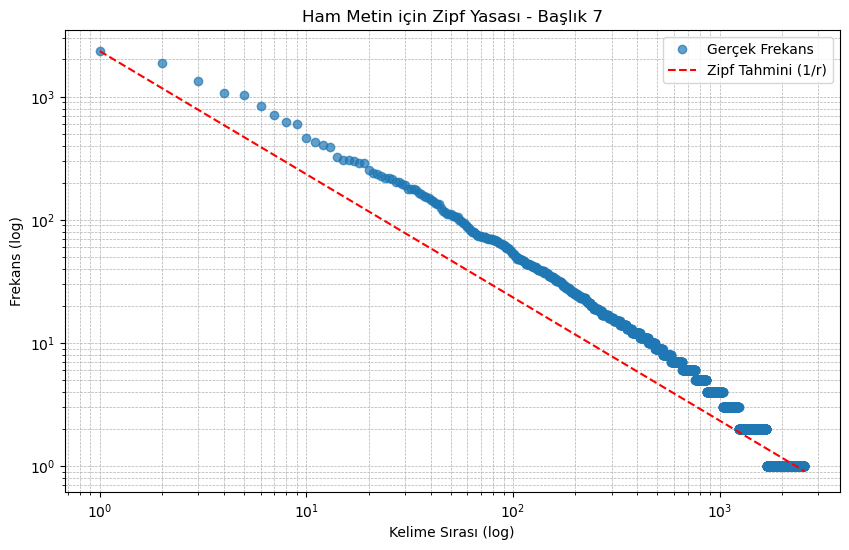

In [28]:
import nltk
import requests
import csv
import nltk
import os
import time
import re
import numpy as np
import gensim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import Counter
from collections import OrderedDict
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict

def maddeyi_getir(baslik, bolum):
    url = f"https://www.law.cornell.edu/uscode/text/{baslik}/{bolum}"
    yanit = requests.get(url)

    if yanit.status_code != 200:
        print(f"")
        return None

    soup = BeautifulSoup(yanit.text, 'html.parser')
    icerik = soup.find("div", class_="section")

    if icerik:
        return icerik.get_text(separator="\n", strip=True)
    else:
        print(f"İçerik bulunamad: Başlık {baslik}, Bölüm {bolum}")
        return None



baslik = 7
bolumler = range(1, 25)

tum_metin = ""
for bolum in bolumler:
    metin = maddeyi_getir(baslik, bolum)
    if metin:
        tum_metin += " " + metin
        time.sleep(1)  # siteyi yormamak için bekleme

# Sadece kelimeleri al, küçük harfe çevir
kelimeler = re.findall(r'\b\w+\b', tum_metin.lower())

# Kelime sıklıklarını say
frekanslar = Counter(kelimeler)

# Zipf için: frekansa göre sırala
sirali = frekanslar.most_common()
frekans_degerleri = [f for _, f in sirali]
siralama = np.arange(1, len(frekans_degerleri) + 1)

# Log-log grafik
plt.figure(figsize=(10, 6))
plt.loglog(siralama, frekans_degerleri, marker='o', linestyle='none', alpha=0.7, label='Gerçek Frekans')
plt.plot(siralama, frekans_degerleri[0] / siralama, 'r--', label='Zipf Tahmini (1/r)')
plt.xlabel('Kelime Sırası (log)')
plt.ylabel('Frekans (log)')
plt.title(f'Ham Metin için Zipf Yasası - Başlık {baslik}')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


Başlık 7 Bölüm 3 alınamadı.
Başlık 7 Bölüm 4 alınamadı.


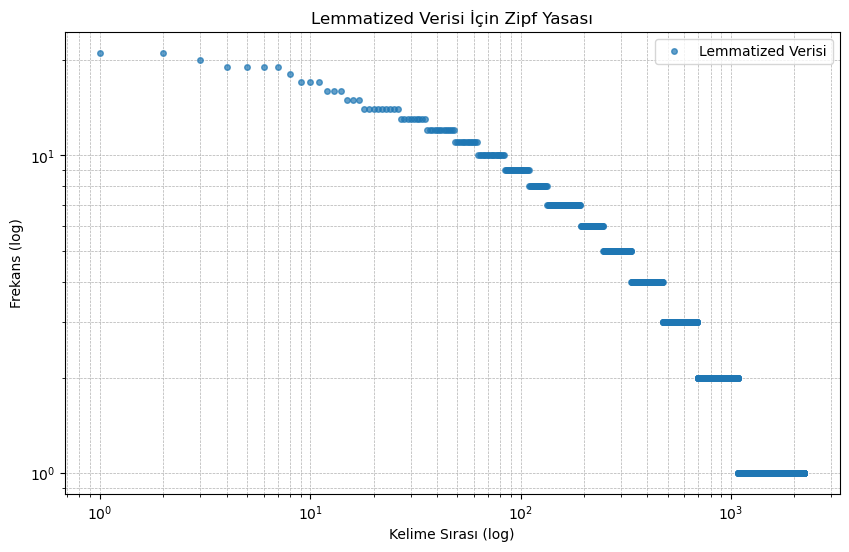

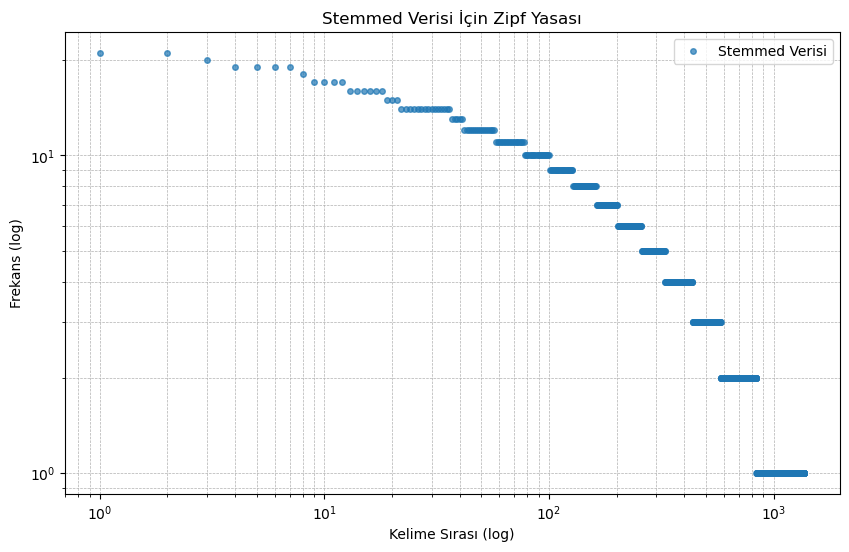

In [29]:
def maddeyi_getir(baslik, bolum):
    url = f"https://www.law.cornell.edu/uscode/text/{baslik}/{bolum}"
    yanit = requests.get(url)

    if yanit.status_code != 200:
        print(f"Başlık {baslik} Bölüm {bolum} alınamadı.")
        return None

    soup = BeautifulSoup(yanit.text, 'html.parser')
    icerik = soup.find("div", class_="section")

    if icerik:
        return icerik.get_text(separator="\n", strip=True)
    else:
        print(f"İçerik bulunamadı: Başlık {baslik}, Bölüm {bolum}")
        return None

def metin_isleme(metin):
    cumleler = sent_tokenize(metin)
    kelimeler = word_tokenize(metin)

    stop_words = set(stopwords.words('english'))
    kelimeler = [kelime for kelime in kelimeler if kelime.lower() not in stop_words and kelime.isalpha()]

    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(kelime) for kelime in kelimeler]

    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(kelime) for kelime in kelimeler]

    return cumleler, kelimeler, lemmatized_words, stemmed_words

baslik = 7
bolumler = range(1,27)  

corpus = []
for bolum in bolumler:
    metin = maddeyi_getir(baslik, bolum)
    if metin:
        corpus.append(metin)
        time.sleep(1)  

tokenized_corpus_lemmatized = []
tokenized_corpus_stemmed = []
tum_cumleler = []

for metin in corpus:
    cumleler, kelimeler, lemmatized_tokens, stemmed_tokens = metin_isleme(metin)

    unique_lemmatized = list(OrderedDict.fromkeys(lemmatized_tokens))
    tokenized_corpus_lemmatized.append(unique_lemmatized)

    unique_stemmed = list(OrderedDict.fromkeys(stemmed_tokens))
    tokenized_corpus_stemmed.append(unique_stemmed)

    tum_cumleler.extend(cumleler)

def zipf_analizi(corpus, label):
    word_freq = Counter([kelime for metin in corpus for kelime in metin])

    sorted_freqs = sorted(word_freq.values(), reverse=True)

    ranks = np.arange(1, len(sorted_freqs) + 1)

    plt.figure(figsize=(10, 6))
    plt.loglog(ranks, sorted_freqs, marker="o", linestyle="none", markersize=4, alpha=0.7, label=f'{label} Verisi')

    plt.xlabel("Kelime Sırası (log)")
    plt.ylabel("Frekans (log)")
    plt.title(f"{label} Verisi İçin Zipf Yasası")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

zipf_analizi(tokenized_corpus_lemmatized, "Lemmatized")

zipf_analizi(tokenized_corpus_stemmed, "Stemmed")

In [30]:
with open("lemmatized_sentences.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Lemmatized Sentence"])
    for tokens in tokenized_corpus_lemmatized:
        writer.writerow([' '.join(tokens)])
print(" lemmatized_sentences.csv dosyasına yazıldı.")


with open("stemmed_sentences.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Stemmed Sentence"])
    for tokens in tokenized_corpus_stemmed:
        writer.writerow([' '.join(tokens)])
print(" stemmed_sentences.csv dosyasına yazıldı.")


 lemmatized_sentences.csv dosyasına yazıldı.
 stemmed_sentences.csv dosyasına yazıldı.


In [31]:
print("\n Örnek Cümleler ve İşlenmiş Hâlleri:\n")
for i in range(min(20, len(tum_cumleler))):
    print(f"Cümle {i+1} - Orijinal: {tum_cumleler[i]}")
    print("\n")
    print(f"Cümle {i+1} - Lemmatized: {tokenized_corpus_lemmatized[i]}")
    print("\n")
    print(f"Cümle {i+1} - Stemmed: {tokenized_corpus_stemmed[i]}")
    print("\n")


 Örnek Cümleler ve İşlenmiş Hâlleri:

Cümle 1 - Orijinal: This chapter may be cited as the “
Commodity Exchange Act
.”
(Sept. 21, 1922, ch.


Cümle 1 - Lemmatized: ['chapter', 'may', 'cited', 'Commodity', 'Exchange', 'Act', 'ch', 'Stat', 'June']


Cümle 1 - Stemmed: ['chapter', 'may', 'cite', 'commod', 'exchang', 'act', 'ch', 'stat', 'june']


Cümle 2 - Orijinal: 369, § 1,
42 Stat.


Cümle 2 - Lemmatized: ['Jurisdiction', 'Commission', 'Commodity', 'Futures', 'Trading', 'general', 'shall', 'exclusive', 'jurisdiction', 'except', 'extent', 'otherwise', 'provided', 'Wall', 'Street', 'Transparency', 'Accountability', 'Act', 'including', 'amendment', 'made', 'subparagraphs', 'C', 'paragraph', 'subsection', 'c', 'f', 'respect', 'account', 'agreement', 'transaction', 'character', 'commonly', 'known', 'trade', 'option', 'privilege', 'indemnity', 'bid', 'offer', 'put', 'call', 'advance', 'guaranty', 'decline', 'involving', 'swap', 'contract', 'sale', 'commodity', 'future', 'delivery', 'signifi

In [32]:
tum_stemmed_kelimeler = []
for tokens in tokenized_corpus_stemmed:
    tum_stemmed_kelimeler.extend(tokens)

tum_lemmatized_kelimeler = []
for tokens in tokenized_corpus_lemmatized:
    tum_lemmatized_kelimeler.extend(tokens)

en_yaygin_stemler = Counter(tum_stemmed_kelimeler).most_common(10)

en_yaygin_lemmalar = Counter(tum_lemmatized_kelimeler).most_common(10)

print("\n En Yaygın 10 Lemmatize Edilmiş Kelime:")
for kelime, frekans in en_yaygin_lemmalar:
    print(f"{kelime}: {frekans}")


print("\n En Yaygın 10 Stem'lenmiş Kelime:")
for kelime, frekans in en_yaygin_stemler:
    print(f"{kelime}: {frekans}")



 En Yaygın 10 Lemmatize Edilmiş Kelime:
ch: 21
Stat: 21
chapter: 20
Commission: 19
shall: 19
title: 19
Pub: 19
b: 18
may: 17
section: 17

 En Yaygın 10 Stem'lenmiş Kelime:
ch: 21
stat: 21
chapter: 20
commiss: 19
shall: 19
titl: 19
pub: 19
b: 18
may: 17
provid: 17


In [33]:
tokenized_corpus_lemmatized[:1]

[['chapter',
  'may',
  'cited',
  'Commodity',
  'Exchange',
  'Act',
  'ch',
  'Stat',
  'June']]

In [34]:
# Ön işlenmiş token listelerini tekrar metne çeviriyoruz
lemmatized_texts = [' '.join(tokens) for tokens in tokenized_corpus_lemmatized]
lemmatized_texts[:3]

['chapter may cited Commodity Exchange Act ch Stat June',
 'Jurisdiction Commission Commodity Futures Trading general shall exclusive jurisdiction except extent otherwise provided Wall Street Transparency Accountability Act including amendment made subparagraphs C paragraph subsection c f respect account agreement transaction character commonly known trade option privilege indemnity bid offer put call advance guaranty decline involving swap contract sale commodity future delivery significant price discovery traded executed market designated pursuant section title execution facility board exchange subject regulation Except hereinabove nothing contained supersede limit time conferred Securities Exchange regulatory authority law United States State II restrict carrying duty responsibility accordance Nothing court B Liability principal act agent omission failure official person acting individual association partnership corporation trust within scope employment office deemed well Designatio

In [35]:
# TF-IDF vektörizerı başlatıyoruz
vectorizer = TfidfVectorizer()
# TF-IDF matrisini oluşturuyoruz
#terim frekansları, belge frekanslarıni hesplar
#TF-IDF vektörlerine dönüştürür
tfidf_matrix = vectorizer.fit_transform(lemmatized_texts)
## Kelimeleri alalım
#F-IDF vektörleştirme işleminde kullanılan tüm kelimelerin essiz bir listesini␣

feature_names = vectorizer.get_feature_names_out()
# TF-IDF matrisini pandas DataFrame'e çevir-gorunurluk acisindan- calismasi␣

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)


In [36]:
print(tfidf_df.head())

         aa  abets  abide   ability  able  abridge  abrogate  abrogation  \
0  0.000000    0.0    0.0  0.000000   0.0      0.0       0.0         0.0   
1  0.049948    0.0    0.0  0.024974   0.0      0.0       0.0         0.0   
2  0.000000    0.0    0.0  0.000000   0.0      0.0       0.0         0.0   
3  0.047005    0.0    0.0  0.047005   0.0      0.0       0.0         0.0   
4  0.000000    0.0    0.0  0.047713   0.0      0.0       0.0         0.0   

      abuse  abused  ...      word    worth     would  writ   writing  \
0  0.000000     0.0  ...  0.000000  0.00000  0.000000   0.0  0.000000   
1  0.054440     0.0  ...  0.030115  0.00000  0.016164   0.0  0.021588   
2  0.000000     0.0  ...  0.000000  0.00000  0.000000   0.0  0.000000   
3  0.000000     0.0  ...  0.000000  0.06436  0.030422   0.0  0.040631   
4  0.052003     0.0  ...  0.000000  0.00000  0.030881   0.0  0.000000   

    written        xi       xii      xiii      year  
0  0.000000  0.000000  0.000000  0.000000  0.00000

In [37]:
tfidf_df.max().sort_values(ascending=False).head(10)


cited           0.637884
invalid         0.403783
validity        0.403783
act             0.402704
remainder       0.355601
circumstance    0.355601
exchange        0.335746
portfolio       0.329366
thereby         0.321414
june            0.301519
dtype: float64

In [38]:
# İlk cümle için TF-IDF skorlarını al
first_sentence_vector = tfidf_df.iloc[0]
# Skorlara göre sırala (yüksekten düşüğe)
top_5_words = first_sentence_vector.sort_values(ascending=False).head(5)
# Sonucu yazdır
print("İlk cümlede en yüksek TF-IDF skoruna sahip 5 kelime:")
print(top_5_words)


İlk cümlede en yüksek TF-IDF skoruna sahip 5 kelime:
cited        0.637884
act          0.402704
exchange     0.335746
june         0.301519
commodity    0.259628
Name: 0, dtype: float64


In [39]:
from sklearn.metrics.pairwise import cosine_similarity

# Python kelimesinin TF-IDF vektörünü alıyoruz
python_index = feature_names.tolist().index("cited")
python_vector = tfidf_matrix[:, python_index].toarray()

# Tüm kelimelerle cosine similarity hesapla
similarities = cosine_similarity(python_vector.T, tfidf_matrix.T).flatten()

# Benzerlikleri sıralayalım
top_5_indices = similarities.argsort()[-6:][::-1]  # En yüksek 5 kelime

# Sonuçları yazdıralım
for index in top_5_indices:
    print(f"{feature_names[index]}: {similarities[index]:.4f}")


cited: 1.0000
june: 0.9345
act: 0.9321
exchange: 0.8996
commodity: 0.8665
may: 0.7325


In [40]:
# En benzer 5 kelimeyi DataFrame olarak hazırlayalım
results = []
for index in top_5_indices:
    results.append({
        "word": feature_names[index],
        "similarity": round(similarities[index], 4)
    })

# DataFrame oluştur
df_results = pd.DataFrame(results)

# Sonuçları CSV'ye kaydet
df_results.to_csv("tfidf_lemmatized_result.csv", index=False)
df_results.to_csv("tfidf_stemmed_result.csv", index=False)

print("Sonuçlar başarıyla CSV dosyalarına kaydedildi.")


Sonuçlar başarıyla CSV dosyalarına kaydedildi.


In [41]:
parameters = [
    {'model_type': 'cbow', 'window': 2, 'vector_size': 100},
    {'model_type': 'skipgram', 'window': 2, 'vector_size': 100},
    {'model_type': 'cbow', 'window': 4, 'vector_size': 100},
    {'model_type': 'skipgram', 'window': 4, 'vector_size': 100},
    {'model_type': 'cbow', 'window': 2, 'vector_size': 300},
    {'model_type': 'skipgram', 'window': 2, 'vector_size': 300},
    {'model_type': 'cbow', 'window': 4, 'vector_size': 300},
    {'model_type': 'skipgram', 'window': 4, 'vector_size': 300}
]

In [42]:
def train_and_save_model_individual_csv(corpus, params, model_name_prefix):
    start_time = time.time()
    
    # Word2Vec eğitimi
    model = Word2Vec(
        corpus,
        vector_size=params['vector_size'],
        window=params['window'],
        min_count=1,
        sg=1 if params['model_type'] == 'skipgram' else 0
    )
    
    # Model adı
    model_filename = f"{model_name_prefix}_{params['model_type']}_window{params['window']}_dim{params['vector_size']}.model"
    model.save(model_filename)
    
    elapsed_time = round(time.time() - start_time, 2)
    
    print(f"{model_filename} saved. Training time: {elapsed_time} sec")

    # CSV dosya adı
    csv_filename = model_filename.replace(".model", ".csv")
    
    # CSV dosyasına yaz
    with open(csv_filename, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Filename", "Corpus_Type", "Model_Type", "Window", "Vector_Size", "Training_Time_Seconds"])
        writer.writerow([
            model_filename,
            model_name_prefix,
            params['model_type'],
            params['window'],
            params['vector_size'],
            elapsed_time
        ])

parameters = [
    {"vector_size": 100, "window": 5, "model_type": "cbow"},
    {"vector_size": 100, "window": 5, "model_type": "skipgram"},
    {"vector_size": 100, "window": 10, "model_type": "cbow"},
    {"vector_size": 100, "window": 10, "model_type": "skipgram"},
    {"vector_size": 300, "window": 5, "model_type": "cbow"},
    {"vector_size": 300, "window": 5, "model_type": "skipgram"},
    {"vector_size": 300, "window": 10, "model_type": "cbow"},
    {"vector_size": 300, "window": 10, "model_type": "skipgram"},
]


# CSV dosyası oluştur
with open("word2vec_model_log.csv", mode="w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Filename", "Corpus_Type", "Model_Type", "Window", "Vector_Size", "Training_Time_Seconds"])
    # Lemmatized modeller
   # Lemmatized modeller
for param in parameters:
    train_and_save_model_individual_csv(tokenized_corpus_lemmatized, param, "lemmatized_model")
print("\n")
# Stemmed modeller
for param in parameters:
    train_and_save_model_individual_csv(tokenized_corpus_stemmed, param, "stemmed_model")



lemmatized_model_cbow_window5_dim100.model saved. Training time: 0.07 sec
lemmatized_model_skipgram_window5_dim100.model saved. Training time: 0.09 sec
lemmatized_model_cbow_window10_dim100.model saved. Training time: 0.05 sec
lemmatized_model_skipgram_window10_dim100.model saved. Training time: 0.15 sec
lemmatized_model_cbow_window5_dim300.model saved. Training time: 0.05 sec
lemmatized_model_skipgram_window5_dim300.model saved. Training time: 0.18 sec
lemmatized_model_cbow_window10_dim300.model saved. Training time: 0.05 sec
lemmatized_model_skipgram_window10_dim300.model saved. Training time: 0.25 sec


stemmed_model_cbow_window5_dim100.model saved. Training time: 0.03 sec
stemmed_model_skipgram_window5_dim100.model saved. Training time: 0.09 sec
stemmed_model_cbow_window10_dim100.model saved. Training time: 0.05 sec
stemmed_model_skipgram_window10_dim100.model saved. Training time: 0.12 sec
stemmed_model_cbow_window5_dim300.model saved. Training time: 0.05 sec
stemmed_model_skipgra

In [43]:
# Model dosyalarını yüklemek
model_1 = Word2Vec.load("lemmatized_model_cbow_window5_dim100.model")
model_2 = Word2Vec.load("lemmatized_model_skipgram_window10_dim300.model")
model_3 = Word2Vec.load("stemmed_model_cbow_window5_dim100.model")
model_4 = Word2Vec.load("stemmed_model_skipgram_window10_dim300.model")
# 'present' kelimesi ile en benzer 3 kelimeyi ve skorlarını yazdırmak
def print_similar_words(model, model_name):
    try:
        similarity = model.wv.most_similar('present', topn=3)
        print(f"\n{model_name} Modeli - 'present' ile En Benzer 3 Kelime:")
        for word, score in similarity:
            print(f"Kelime: {word}, Benzerlik Skoru: {score:.4f}")
    except KeyError:
        print(f"\n{model_name} Modeli - 'present' kelimesi bulunamadı.")


# 4 model için benzer kelimeleri yazdır
print_similar_words(model_1, "Lemmatized CBOW Window 5 Dim 100")
print_similar_words(model_2, "Lemmatized Skipgram Window 10 Dim 300")
print_similar_words(model_3, "Stemmed CBOW Window 5 Dim 100")
print_similar_words(model_4, "stemmed Skipgram Window 10 Dim 300")


Lemmatized CBOW Window 5 Dim 100 Modeli - 'present' ile En Benzer 3 Kelime:
Kelime: electric, Benzerlik Skoru: 0.3723
Kelime: transmittal, Benzerlik Skoru: 0.3160
Kelime: deem, Benzerlik Skoru: 0.3006

Lemmatized Skipgram Window 10 Dim 300 Modeli - 'present' ile En Benzer 3 Kelime:
Kelime: thereof, Benzerlik Skoru: 0.9748
Kelime: f, Benzerlik Skoru: 0.9748
Kelime: chapter, Benzerlik Skoru: 0.9747

Stemmed CBOW Window 5 Dim 100 Modeli - 'present' ile En Benzer 3 Kelime:
Kelime: forth, Benzerlik Skoru: 0.3373
Kelime: audit, Benzerlik Skoru: 0.3123
Kelime: defin, Benzerlik Skoru: 0.2882

stemmed Skipgram Window 10 Dim 300 Modeli - 'present' ile En Benzer 3 Kelime:
Kelime: caus, Benzerlik Skoru: 0.9993
Kelime: relat, Benzerlik Skoru: 0.9992
Kelime: report, Benzerlik Skoru: 0.9992
